Recognize google street view house number multi digits, dataset is from format 1.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Get prepared data from pickle file:

In [2]:
pickle_file = 'google_svhn_multi_digits_version3.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save
    
    print('Train:', train_dataset.shape, train_labels.shape)
    print('Test:', test_dataset.shape, test_labels.shape)
    print('Valid:', valid_dataset.shape, valid_labels.shape)

Train: (28401, 32, 32) (28401, 6)
Test: (13068, 32, 32) (13068, 6)
Valid: (5000, 32, 32) (5000, 6)


Check if the dataset are ok:

In [3]:
import random

def display_sample_image(dataset, label, title = None):
    if title:
        plt.suptitle(title, fontsize = 12)
        
    items = random.sample(range(label.shape[0]), 12)

    for i,item in enumerate(items):
        plt.subplot(3,4,i+1)
        plt.axis('off')
        plt.title(label[item][1:(label[item][0] + 1)])
        plt.imshow(dataset[item, :, :])
        
    plt.show()

TypeError: Invalid dimensions for image data

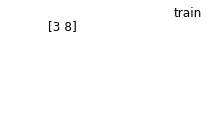

In [33]:
display_sample_image(train_dataset, train_labels, 'train')
display_sample_image(valid_dataset, valid_labels, 'valid')
display_sample_image(test_dataset, test_labels, 'test')

In [5]:
print('Train:', np.mean(train_dataset), np.std(train_dataset))
print('Valid:', np.mean(valid_dataset), np.std(valid_dataset))
print('Test:', np.mean(test_dataset), np.std(test_dataset))
assert not np.any(np.isnan(train_dataset)) # check that there is no nan in the input data
assert not np.any(np.isnan(train_labels))
assert not np.any(np.isnan(valid_dataset))
assert not np.any(np.isnan(valid_labels))
assert not np.any(np.isnan(test_dataset))
assert not np.any(np.isnan(test_labels))

Train: 2.26456e-09 0.5
Valid: 4.20758e-09 0.5
Test: 1.6018e-09 0.5


Check if any label length indicates 0:

In [6]:
print(np.any(train_labels[:,0] == 0))
print(np.any(valid_labels[:,0] == 0))
print(np.any(test_labels[:,0] == 0))

False
False
False


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
// - labels as float 1-hot encodings. (first length, then 1-5 five digits)

In [7]:
image_size = 32
#num_labels = 10 # 1-10, 1-9 represents 1-9, 10 represents 0
num_labels = 11 # 0 - 10
num_channels = 1 #grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)

  #labels = (np.arange(1,num_labels + 1) == labels[:,:,None]).astype(np.float32)
  #labels = np.squeeze(labels)

  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Train:', train_dataset.shape, train_labels.shape)
print('Test:', test_dataset.shape, test_labels.shape)
print('Valid:', valid_dataset.shape, valid_labels.shape)

Train: (28401, 32, 32, 1) (28401, 6)
Test: (13068, 32, 32, 1) (13068, 6)
Valid: (5000, 32, 32, 1) (5000, 6)


Check if 1-hot encoding labels are alright:

In [8]:
#print(np.argmax(test_labels[590], axis = 1) + 1)

In [15]:
# calculate single-character accuracy
def accuracy_single(predictions, labels):
    a = np.argmax(predictions, axis = 2) == labels
    length = labels[:,0]
    sum = 0.0
    for i in range(predictions.shape[0]):
        sum += np.sum(a[i][1:(length[i] + 1)])
    return (100 * sum / (np.sum(length)))
    

In [16]:
# all digits has be correct to be considered as accurate
def accuracy(predictions, labels):
    accuracy = 0
    for index in range(predictions.shape[0]):
        accuracy += np.prod(np.argmax(predictions[index], 1
                                     )[:(labels[index][0] + 1)] == 
                            labels[index][:(labels[index][0] + 1)])
        
    accuracy = 100.0 * accuracy / predictions.shape[0]
    
    return accuracy

In [17]:
def fake_prediction(labels):
    output = (np.arange(num_labels) == labels[:,:,None]).astype(np.float32)
    return output

fake_valid_prediction = fake_prediction(valid_labels)
fake_test_prediction = fake_prediction(test_labels)

print(accuracy_single(fake_valid_prediction, valid_labels))
print(accuracy(fake_valid_prediction, valid_labels))


100.0
100.0


Let's build a small network with 3*(convolution layer + relu + max pooling), followed by 2 fully connected layers, with L2 regulation to prevent overfitting.

In [29]:
label_length = 6 # length + 5 digits
batch_size = 64
patch_size = 5
depth_1 = 32
depth_2 = 32
depth_3 = 64
num_hidden_1 = 512
num_hidden_2 = 1024
initial_learning_rate = 0.003
decay_steps = 5000
decay_rate = 0.8
cnn_keep_prob = 0.8
fc_keep_prob = 0.5

graph = tf.Graph()

with graph.as_default():
    
    def bias_variable(shape):
        output = tf.ones(shape)
        return tf.Variable(output)
    
    def get_cnn_wb(weight_name, shape):
        weight = tf.get_variable(weight_name, shape = shape,
                           initializer = tf.contrib.layers.xavier_initializer_conv2d())
        bias = bias_variable(shape[-1])
        return weight, bias
    
    def get_variable_wb(weight_name, shape):
        weight = tf.get_variable(weight_name, shape = shape,
                           initializer = tf.contrib.layers.xavier_initializer())
        bias = bias_variable(shape[-1])
        return weight, bias
        
    def conv_relu(data, weight, bias):
        conv = tf.nn.conv2d(data, weight, [1,1,1,1], padding = 'SAME')
        hidden = tf.nn.relu(conv + bias)
        return hidden
    
    def max_pooling(data):
        output = tf.nn.max_pool(data, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
        return output
    
    #Input data
    tf_train_dataset = tf.placeholder(
        tf.float32, shape = (batch_size, image_size, image_size, num_channels))
    #tf_train_labels = tf.placeholder(
    #    tf.float32, shape = (batch_size, label_length, num_labels))
    tf_train_labels = tf.placeholder(
        tf.int32, shape = (batch_size, label_length))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta_regul = tf.placeholder(tf.float32)
    
    global_step = tf.Variable(0) # count number of steps taken
    
    # Variables
    # CNN variables
    
    cnn1_w, cnn1_b = get_cnn_wb('cnn1_w', [patch_size, patch_size, num_channels, depth_1])
    cnn2_w, cnn2_b = get_cnn_wb('cnn2_w', [patch_size, patch_size, depth_1, depth_2])
    cnn3_w, cnn3_b = get_cnn_wb('cnn3_w', [patch_size, patch_size, depth_2, depth_3])
    
    # Fully connected layers variables 
    
    fc1_w, fc1_b = get_variable_wb('fc1_w', [(image_size//8)*(image_size//8)*depth_3, num_hidden_1])   
    fc2_w, fc2_b = get_variable_wb('fc2_w', [num_hidden_1,num_hidden_2])

    # Output layer variables  
    output_weight_shape = [num_hidden_2, num_labels]
    
    length_w, length_b =  get_variable_wb('length_w', output_weight_shape)
    
    d1_w,d1_b = get_variable_wb('d1_w', output_weight_shape)
    d2_w,d2_b = get_variable_wb('d2_w', output_weight_shape)
    d3_w,d3_b = get_variable_wb('d3_w', output_weight_shape)
    d4_w,d4_b = get_variable_wb('d4_w', output_weight_shape)
    d5_w,d5_b = get_variable_wb('d5_w', output_weight_shape)
    
    output_w = [length_w, d1_w, d2_w, d3_w, d4_w, d5_w]
    
    # Model
    def model(data):
        # convolution 1 + relu
        hidden = conv_relu(data, cnn1_w, cnn1_b)
        #hidden = tf.nn.local_response_normalization(hidden)
        # 32 * 32 * depth1
        
        # max pooling 1
        max_pool = max_pooling(hidden)
        # 16 * 16 * depth1
        dropout = max_pool
        #dropout = tf.nn.dropout(max_pool, keep_prob = cnn_keep_prop)
        
        # convolution 2 + relu
        hidden = conv_relu(dropout, cnn2_w, cnn2_b)
        #hidden = tf.nn.local_response_normalization(hidden)
        # 16 * 16 * depth2
        
        # max pooling 2
        max_pool = max_pooling(hidden)
        # 8 * 8 * depth2
        #dropout = max_pool
        dropout = tf.nn.dropout(max_pool, keep_prob = cnn_keep_prob)
        
        # convolution 3 + relu
        hidden = conv_relu(dropout, cnn3_w, cnn3_b)
        #hidden = tf.nn.local_response_normalization(hidden)
        # 8 * 8 * depth3
        
        # max pooling 3
        max_pool = max_pooling(hidden)
        # 4 * 4 * depth3
        #dropout = max_pool
        dropout = tf.nn.dropout(max_pool, keep_prob = cnn_keep_prob)
        
        # reshape
        shape = dropout.get_shape().as_list()
        reshape = tf.reshape(dropout,[shape[0], shape[1]*shape[2]*shape[3]])
        
        # fully connected 1
        y1 = tf.nn.relu(tf.matmul(reshape, fc1_w) + fc1_b)
        #y1_dropout = tf.nn.dropout(y1, fc_keep_prob)
        y1_dropout = y1
        
        # fully connected 2
        y2 = tf.nn.relu(tf.matmul(y1_dropout, fc2_w) + fc2_b)
        y2_dropout = tf.nn.dropout(y2, fc_keep_prob)
        
        # length logits
        length_logits = tf.matmul(y2_dropout, length_w) + length_b
        
        # logits for each digits
        d1_logits = tf.matmul(y2_dropout, d1_w) + d1_b
        d2_logits = tf.matmul(y2_dropout, d2_w) + d2_b
        d3_logits = tf.matmul(y2_dropout, d3_w) + d3_b
        d4_logits = tf.matmul(y2_dropout, d4_w) + d4_b
        d5_logits = tf.matmul(y2_dropout, d5_w) + d5_b
        
        logits = tf.stack([length_logits, d1_logits, d2_logits, 
                           d3_logits, d4_logits, d5_logits], axis = 1)
        
        return logits
    
    # Training computation
    logits = model(tf_train_dataset)
    
    '''
    length_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = logits[:,0,:], labels = tf_train_labels[:,0,:]))
    digit1_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = logits[:,1,:], labels = tf_train_labels[:,1,:]))
    digit2_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = logits[:,2,:], labels = tf_train_labels[:,2,:]))
    digit3_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = logits[:,3,:], labels = tf_train_labels[:,3,:]))
    digit4_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = logits[:,4,:], labels = tf_train_labels[:,4,:]))
    digit5_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = logits[:,5,:], labels = tf_train_labels[:,5,:]))
       
    l2_loss = tf_beta_regul*(tf.nn.l2_loss(fc1_w))

    loss = length_loss + digit1_loss + digit2_loss + digit3_loss + \
    digit4_loss + digit5_loss + l2_loss
    '''
    
    loss_per_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = logits[:, i, :], labels = tf_train_labels[:, i])) + tf_beta_regul *\
                      (tf.nn.l2_loss(output_w[i])) for i in range(label_length)]   
    
    l2_loss = tf_beta_regul*(tf.nn.l2_loss(fc1_w))
    
    loss = tf.add_n(loss_per_digit) + l2_loss

    
    # Learning rate
    learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                               global_step, decay_steps, decay_rate)
    
    # Optimizer
    #optimizer = tf.train.GradientDescentOptimizer(
    #    learning_rate).minimize(loss, global_step = global_step)
    optimizer = tf.train.AdamOptimizer(
        learning_rate).minimize(loss, global_step = global_step)
    
    # Predictions for training, validation, and test data
    train_prediction = tf.nn.softmax(logits)
    # prediction has shape (batch_size, label_length, 11)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [30]:
num_steps = 100001
num_step = []
validation_accuracy = []
beta_regul = 0.00055
total_loss = []

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        #batch_labels = train_labels[offset:(offset + batch_size), :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset: batch_data,
                    tf_train_labels: batch_labels,
                    tf_beta_regul: beta_regul}
        
        _, l, prediction = session.run(
            [optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        # print out progress
        if(step % 500 == 0):
            num_step.append(step)
            validation_accuracy.append(accuracy(
                valid_prediction.eval(), valid_labels))
            total_loss.append(l)

            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(prediction, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
            print('Validation single digit accuracy:%.1f%%' % accuracy_single(
                valid_prediction.eval(), valid_labels))
        if(step % 10000 == 0):
            print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
            print('Test single digit accuracy: ', accuracy_single(
                test_prediction.eval(), test_labels))
            # this is an aggressive way of getting prediction results
            #test_result = np.argmax(test_prediction.eval(), axis = 2) + 1
            test_result = np.argmax(test_prediction.eval(), axis = 2)


Initialized
Minibatch loss at step 0: 35.569633
Minibatch accuracy: 0.0%
Validation accuracy: 0.9%
Validation single digit accuracy:14.2%
Test accuracy: 1.4%
Test single digit accuracy:  14.7510755993
Minibatch loss at step 500: 7.153052
Minibatch accuracy: 3.1%
Validation accuracy: 1.4%
Validation single digit accuracy:19.4%
Minibatch loss at step 1000: 6.597528
Minibatch accuracy: 4.7%
Validation accuracy: 7.1%
Validation single digit accuracy:25.9%
Minibatch loss at step 1500: 4.469477
Minibatch accuracy: 21.9%
Validation accuracy: 20.9%
Validation single digit accuracy:39.5%
Minibatch loss at step 2000: 4.409321
Minibatch accuracy: 32.8%
Validation accuracy: 26.1%
Validation single digit accuracy:46.9%
Minibatch loss at step 2500: 4.137032
Minibatch accuracy: 31.2%
Validation accuracy: 33.4%
Validation single digit accuracy:52.6%
Minibatch loss at step 3000: 3.732267
Minibatch accuracy: 29.7%
Validation accuracy: 37.4%
Validation single digit accuracy:54.6%
Minibatch loss at step 3

Minibatch loss at step 30500: 1.201267
Minibatch accuracy: 73.4%
Validation accuracy: 66.6%
Validation single digit accuracy:79.0%
Minibatch loss at step 31000: 1.612131
Minibatch accuracy: 65.6%
Validation accuracy: 67.1%
Validation single digit accuracy:79.4%
Minibatch loss at step 31500: 1.267345
Minibatch accuracy: 78.1%
Validation accuracy: 67.2%
Validation single digit accuracy:80.4%
Minibatch loss at step 32000: 0.987384
Minibatch accuracy: 76.6%
Validation accuracy: 66.5%
Validation single digit accuracy:79.4%
Minibatch loss at step 32500: 1.230013
Minibatch accuracy: 76.6%
Validation accuracy: 67.6%
Validation single digit accuracy:79.7%
Minibatch loss at step 33000: 0.903025
Minibatch accuracy: 87.5%
Validation accuracy: 67.2%
Validation single digit accuracy:80.1%
Minibatch loss at step 33500: 1.487245
Minibatch accuracy: 73.4%
Validation accuracy: 67.7%
Validation single digit accuracy:79.9%
Minibatch loss at step 34000: 1.198313
Minibatch accuracy: 78.1%
Validation accurac

Validation accuracy: 69.8%
Validation single digit accuracy:81.7%
Minibatch loss at step 61500: 0.648224
Minibatch accuracy: 89.1%
Validation accuracy: 70.3%
Validation single digit accuracy:81.8%
Minibatch loss at step 62000: 0.501095
Minibatch accuracy: 90.6%
Validation accuracy: 70.1%
Validation single digit accuracy:81.7%
Minibatch loss at step 62500: 0.548976
Minibatch accuracy: 92.2%
Validation accuracy: 70.0%
Validation single digit accuracy:81.3%
Minibatch loss at step 63000: 0.536018
Minibatch accuracy: 87.5%
Validation accuracy: 70.5%
Validation single digit accuracy:81.8%
Minibatch loss at step 63500: 0.529156
Minibatch accuracy: 93.8%
Validation accuracy: 69.9%
Validation single digit accuracy:81.7%
Minibatch loss at step 64000: 0.511641
Minibatch accuracy: 92.2%
Validation accuracy: 70.4%
Validation single digit accuracy:81.9%
Minibatch loss at step 64500: 0.402166
Minibatch accuracy: 92.2%
Validation accuracy: 71.1%
Validation single digit accuracy:81.8%
Minibatch loss at

Validation single digit accuracy:82.5%
Minibatch loss at step 92000: 0.364062
Minibatch accuracy: 95.3%
Validation accuracy: 70.9%
Validation single digit accuracy:82.5%
Minibatch loss at step 92500: 0.330661
Minibatch accuracy: 98.4%
Validation accuracy: 70.4%
Validation single digit accuracy:82.4%
Minibatch loss at step 93000: 0.403733
Minibatch accuracy: 90.6%
Validation accuracy: 70.7%
Validation single digit accuracy:82.6%
Minibatch loss at step 93500: 0.353197
Minibatch accuracy: 92.2%
Validation accuracy: 71.7%
Validation single digit accuracy:82.2%
Minibatch loss at step 94000: 0.498963
Minibatch accuracy: 89.1%
Validation accuracy: 71.0%
Validation single digit accuracy:82.1%
Minibatch loss at step 94500: 0.343667
Minibatch accuracy: 93.8%
Validation accuracy: 71.1%
Validation single digit accuracy:82.4%
Minibatch loss at step 95000: 0.445333
Minibatch accuracy: 92.2%
Validation accuracy: 71.4%
Validation single digit accuracy:82.4%
Minibatch loss at step 95500: 0.440600
Minib

In [31]:
import random

def display_sample_image(dataset, label, title = None):
    if title:
        plt.suptitle(title, fontsize = 12)
        
    items = random.sample(range(label.shape[0]), 12)

    for i,item in enumerate(items):
        plt.subplot(3,4,i+1)
        plt.axis('off')
        plt.title(label[item][1:(label[item][0] + 1)])
        plt.imshow(dataset[item, :, :])
        
    plt.show()

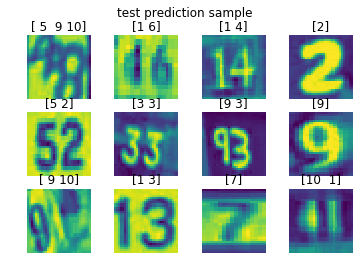

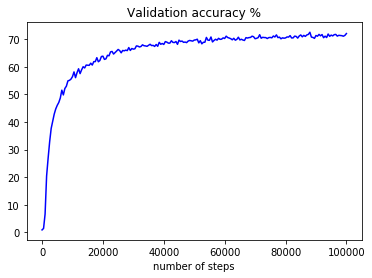

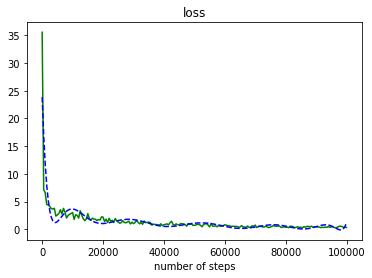

In [37]:
# plot test prediction sample
test_dataset_temp = np.squeeze(test_dataset)
display_sample_image(test_dataset_temp, test_result, 'test prediction sample')

# plot validation accuracy
plt.plot(num_step, validation_accuracy, 'b-')
plt.title('Validation accuracy %')
plt.xlabel('number of steps')
plt.show()

# plot loss
poly_para = np.polyfit(num_step, total_loss, deg=12)
loss_polyfit = np.polyval(poly_para, num_step)

plt.plot(num_step, total_loss, 'g-')
plt.plot(num_step, loss_polyfit, 'b--')
plt.title('loss')
plt.xlabel('number of steps')
plt.show()
